<a href="https://www.kaggle.com/code/zainabahmad30/implementasi-generative-adversarial-network-gan?scriptVersionId=250264841" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Generative Adversarial Network (GAN)

Generative Adversarial Network (GAN) adalah salah satu inovasi revolusioner dalam bidang *deep learning* yang diperkenalkan oleh Ian Goodfellow dan timnya pada tahun 2014. GAN merupakan arsitektur pembelajaran mesin yang digunakan untuk menghasilkan data baru yang menyerupai data asli. GAN terdiri dari dua jaringan saraf utama yang saling berkompetisi, yaitu:

- **Generator (G):** Bertugas menghasilkan data sintetis (misalnya gambar) dari input berupa noise atau vektor acak. Tujuannya adalah membuat data palsu ini sebisa mungkin menyerupai data nyata.
- **Discriminator (D):** Bertugas membedakan apakah suatu data berasal dari dataset asli atau dari hasil buatan generator.

Kedua model ini dilatih secara bersamaan dalam suatu kerangka permainan zero-sum (minimax game). Generator mencoba "menipu" discriminator, sementara discriminator belajar untuk membedakan mana data nyata dan mana yang palsu. Proses ini berlanjut hingga keduanya mencapai titik keseimbangan, di mana discriminator tidak lagi dapat membedakan secara pasti antara data asli dan data hasil generator.

Secara matematis, GAN mengoptimalkan fungsi objektif sebagai berikut:

> **min<sub>G</sub> max<sub>D</sub> V(D, G) = E<sub>x~p<sub>data</sub>(x)</sub>[log D(x)] + E<sub>z~p<sub>z</sub>(z)</sub>[log(1 - D(G(z)))]**

Pada tugas ini, kami akan mengimplementasikan GAN sederhana menggunakan framework **PyTorch**, dan melatihnya untuk menghasilkan gambar yang menyerupai angka tulisan tangan menggunakan dataset **MNIST**. Dengan pendekatan ini, kami ingin mengeksplorasi bagaimana GAN belajar menciptakan struktur visual kompleks dari input acak melalui proses kompetisi dan pembelajaran simultan.

Hasil yang diharapkan adalah:
- Visualisasi perkembangan kualitas gambar dari waktu ke waktu (epoch),
- Analisis loss fungsi Generator dan Discriminator,
- Serta pemahaman praktis tentang bagaimana jaringan adversarial bekerja.



# 1. Import Library

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os
import numpy as np


Penjelasan:


- torch, torch.nn: Library utama PyTorch untuk membuat model dan operasi tensor.

- torchvision: Untuk memuat dataset dan fungsi visualisasi.

- transforms: Untuk preprocessing dataset seperti normalisasi.

- DataLoader: Untuk membungkus dataset menjadi mini-batch.

- save_image, make_grid: Untuk menyimpan dan menampilkan hasil gambar dari generator.

- matplotlib.pyplot: Untuk plotting loss selama training.

- os, numpy: Utilitas sistem dan manipulasi array.

# 2. Setup Folder

In [2]:
os.makedirs("generated_images", exist_ok=True)
os.makedirs("models", exist_ok=True)


Penjelasan:


- Membuat folder generated_images untuk menyimpan gambar hasil generator setiap beberapa epoch.

- Membuat folder models untuk menyimpan file model .pth.

# 3. Dataset (MNIST)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 57.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.05MB/s]


Penjelasan:


- ToTensor(): Mengubah gambar menjadi tensor PyTorch (nilai 0–1).

- Normalize([0.5], [0.5]): Normalisasi data agar berada di rentang -1 sampai 1 (dibutuhkan untuk Tanh).

- DataLoader: Membagi data menjadi batch (128 gambar per batch) dan mengacak data (shuffle=True).

# 4. Arsitektur Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, img_size=28):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_size * img_size),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        return img.view(z.size(0), 1, 28, 28)


Penjelasan:

- Input: vektor acak (noise) berdimensi 100.

- Generator terdiri dari beberapa lapisan Linear + aktivasi ReLU.

- Output dikembalikan ke bentuk gambar 28x28 piksel (1 channel) dan aktivasi Tanh agar nilainya antara -1 dan 1 (cocok dengan hasil normalisasi data).

- view(z.size(0), 1, 28, 28) mengubah output dari vektor ke bentuk gambar.

# 5. Arsitektur Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=28*28):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        flat = img.view(img.size(0), -1)
        return self.model(flat)


Penjelasan:


- Input: gambar (28x28) di-flatten jadi vektor 784 elemen.

- Aktivasi: LeakyReLU digunakan agar gradien tetap mengalir meskipun nilai input negatif.

- Output: 1 nilai antara 0–1, yang menunjukkan apakah gambar asli (1) atau palsu (0).

- Sigmoid() digunakan agar output dapat dibandingkan dengan label nyata.

# 6. Inisialisasi Model dan Optimizer

In [6]:
G = Generator()
D = Discriminator()
loss_fn = nn.BCELoss()

G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
G.to(device)
D.to(device)


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Penjelasan:


- Menginisialisasi generator dan discriminator.

- Loss function yang digunakan adalah Binary Cross Entropy Loss (BCELoss) karena kita melakukan klasifikasi biner (real/fake).

- Optimizer: Adam, dengan learning rate kecil (0.0002), umum digunakan pada GAN.

- to(device): Memastikan model berjalan di GPU jika tersedia.

7. Training Loop GAN

In [7]:
num_epochs = 50
loss_G, loss_D = [], []

for epoch in range(1, num_epochs+1):
    G.train()
    D.train()
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        #  Train Generator
        # ---------------------
        z = torch.randn(batch_size, 100).to(device)
        gen_imgs = G(z)

        G_loss = loss_fn(D(gen_imgs), valid)

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        real_loss = loss_fn(D(real_imgs), valid)
        fake_loss = loss_fn(D(gen_imgs.detach()), fake)
        D_loss = (real_loss + fake_loss) / 2

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
    
    # Logging loss
    loss_G.append(G_loss.item())
    loss_D.append(D_loss.item())

    # Save generated image every 10 epochs
    if epoch % 10 == 0:
        save_image(gen_imgs.data[:25], f"generated_images/epoch_{epoch}.png", nrow=5, normalize=True)

    print(f"Epoch [{epoch}/{num_epochs}] Loss D: {D_loss.item():.4f}, Loss G: {G_loss.item():.4f}")


Epoch [1/50] Loss D: 0.0113, Loss G: 4.7213
Epoch [2/50] Loss D: 0.1016, Loss G: 3.3949
Epoch [3/50] Loss D: 0.0595, Loss G: 4.2119
Epoch [4/50] Loss D: 0.3558, Loss G: 2.0384
Epoch [5/50] Loss D: 0.0822, Loss G: 5.3995
Epoch [6/50] Loss D: 0.0129, Loss G: 5.1905
Epoch [7/50] Loss D: 0.1176, Loss G: 4.8110
Epoch [8/50] Loss D: 0.0950, Loss G: 3.4830
Epoch [9/50] Loss D: 0.0419, Loss G: 3.9096
Epoch [10/50] Loss D: 0.0448, Loss G: 6.1699
Epoch [11/50] Loss D: 0.0558, Loss G: 4.8280
Epoch [12/50] Loss D: 0.0148, Loss G: 4.4715
Epoch [13/50] Loss D: 0.0434, Loss G: 3.8269
Epoch [14/50] Loss D: 0.0512, Loss G: 8.3106
Epoch [15/50] Loss D: 0.0789, Loss G: 5.0324
Epoch [16/50] Loss D: 0.0447, Loss G: 5.2875
Epoch [17/50] Loss D: 0.0631, Loss G: 3.9233
Epoch [18/50] Loss D: 0.0892, Loss G: 5.5102
Epoch [19/50] Loss D: 0.0455, Loss G: 5.8020
Epoch [20/50] Loss D: 0.0668, Loss G: 7.0299
Epoch [21/50] Loss D: 0.0435, Loss G: 6.3574
Epoch [22/50] Loss D: 0.1132, Loss G: 4.2394
Epoch [23/50] Loss 

Penjelasan:


- Untuk setiap epoch, dilakukan pelatihan Generator dan Discriminator secara bergantian.

- Generator mencoba membuat gambar yang bisa "menipu" Discriminator.

- Discriminator belajar membedakan gambar asli vs hasil Generator.

- detach() digunakan agar gradien tidak mengalir ke Generator saat Discriminator dilatih.

- Setiap 10 epoch, hasil gambar disimpan ke folder.

# 8. Visualisasi Loss

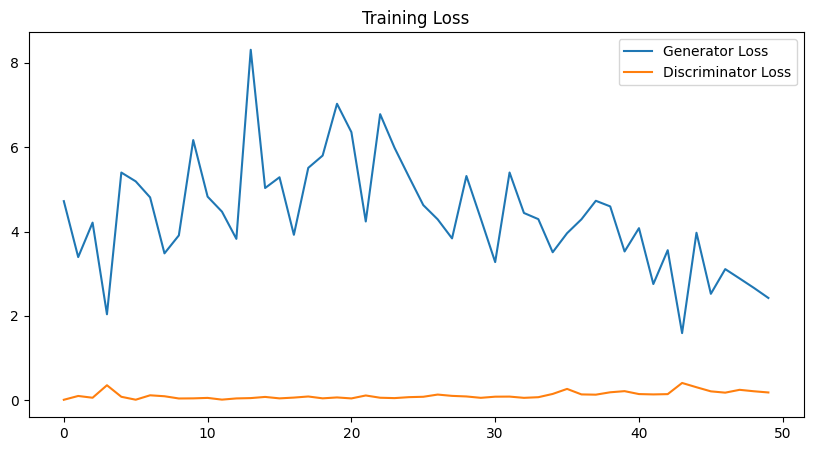

In [8]:
plt.figure(figsize=(10,5))
plt.plot(loss_G, label='Generator Loss')
plt.plot(loss_D, label='Discriminator Loss')
plt.legend()
plt.title("Training Loss")
plt.show()


Penjelasan:


- Visualisasi grafik perubahan loss dari Generator dan Discriminator selama proses pelatihan.

- Tujuannya untuk mengevaluasi kestabilan GAN (idealnya tidak terlalu naik-turun drastis).

# 9. Menampilkan Gambar Hasil Akhir

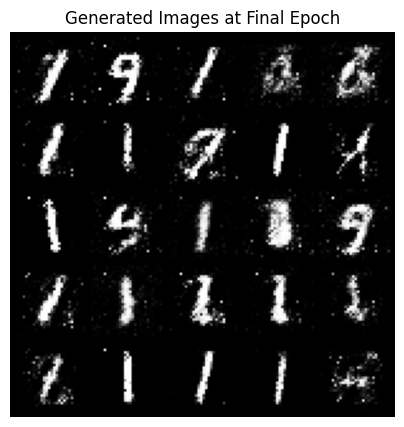

In [9]:
# Tampilkan gambar terakhir
z = torch.randn(25, 100).to(device)
gen_imgs = G(z)
grid = make_grid(gen_imgs.cpu().detach(), nrow=5, normalize=True)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis("off")
plt.title("Generated Images at Final Epoch")
plt.show()


Penjelasan:

- Membuat 25 gambar dari noise secara acak.

- make_grid: Menyusun gambar jadi 1 grid besar untuk visualisasi.

- np.transpose(grid, (1,2,0): Menyesuaikan format array gambar agar bisa ditampilkan matplotlib.

# 10. Menyimpan Model

In [10]:
torch.save(G.state_dict(), "models/generator.pth")
torch.save(D.state_dict(), "models/discriminator.pth")


Penjelasan:


- Menyimpan bobot hasil training untuk digunakan kembali tanpa perlu retrain dari awal.

- File .pth bisa di-load dengan load_state_dict.

## Refleksi Kelompok

Melalui tugas ini, kami belajar bahwa membangun dan melatih model Generative Adversarial Network (GAN) tidak hanya membutuhkan pemahaman arsitektur, tetapi juga kesabaran dan ketelitian dalam eksperimen.

Pada awalnya, kami mengira bahwa cukup dengan membangun model Generator dan Discriminator, maka hasil gambar akan langsung terlihat nyata. Namun, realitanya berbeda. Di epoch-epoch awal, gambar yang dihasilkan masih tampak seperti noise acak dan belum membentuk pola yang bermakna. Seiring bertambahnya epoch, kami melihat perkembangan signifikan—angka mulai terbentuk, dan detail visual meningkat. Hal ini menunjukkan bahwa GAN memang memerlukan proses pelatihan berulang yang seimbang antara Generator dan Discriminator.

Kami juga mengalami tantangan dalam menjaga stabilitas loss dan mencegah mode collapse (di mana Generator hanya menghasilkan satu pola gambar yang sama). Dari sini, kami belajar pentingnya memilih arsitektur yang tepat, fungsi aktivasi yang sesuai, serta parameter optimisasi yang stabil (misalnya learning rate kecil, dan penggunaan `LeakyReLU`).

Secara tim, tugas ini mendorong kami untuk berkolaborasi aktif: membagi tugas implementasi model, membuat dokumentasi, hingga mengelola commit GitHub secara adil. Setiap anggota kelompok memberikan kontribusi nyata yang tercermin dalam riwayat commit. Kami juga saling memberi masukan dalam interpretasi hasil training, debugging error, dan menyusun laporan akhir.

Tugas ini memperkuat pemahaman kami tentang bagaimana deep learning bukan hanya soal model, tetapi juga eksperimen, komunikasi tim, dan dokumentasi teknis. Pengalaman ini menjadi bekal penting untuk proyek-proyek berbasis AI lainnya di masa mendatang.
